# Task
This dataset is of casting manufacturing product.
Casting is a manufacturing process in which a liquid material is usually poured into a mould, which contains a hollow cavity of the desired shape, and then allowed to solidify.
Reason for collect this data is casting defects!!
Casting defect is an undesired irregularity in a metal casting process.
There are many types of defect in casting like blow holes, pinholes, burr, shrinkage defects, mould material defects, pouring metal defects, metallurgical defects, etc.
Defects are an unwanted thing in casting industry. For removing this defective product all industry have their quality inspection department. But the main problem is this inspection process is carried out manually. It is a very time-consuming process and due to human accuracy, this is not 100% accurate. This can because of the rejection of the whole order. So it creates a big loss in the company.

We decided to make the inspection process automatic and for this, we need to make deep learning classification model for this problem.

contain
These all photos are top view of submersible pump impeller(google search for better understanding).
The dataset contains total 7348 image data. These all are the size of (300*300) pixels grey-scaled images. In all images, augmentation already applied.

Also uploaded images size of 512x512 grayscale. This data set is without Augmentation. This contains 519 ok_front and 781 def_front impeller images.

For capturing these images requires stable lighting, for this we made a special arrangement.

there are mainly two categories:-
1) Defective
2)Ok

making classification model we already split data for training and testing into two folders.
Both train and test folder contains def_front and ok_front subfolders.

train:- def_front have 3758 and ok_front have 2875 images
test:- def_front have:- def_front have 453 and ok_front have 262 images

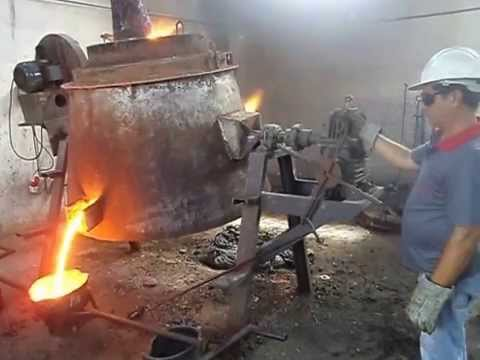

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo("4Lo3tcrz8U0")

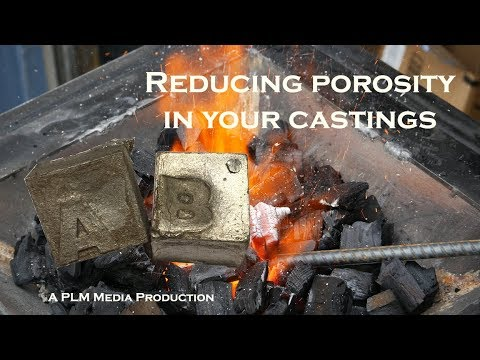

In [11]:
YouTubeVideo("OmmEXUnL4_8")

In [13]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px
import cv2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
# from torchviz import make_dot
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from PIL import Image



import holoviews as hv
from holoviews import opts
#hv.extension('bokeh')
import json
import shap

# load data

In [14]:
my_data_dir = f'./data/casting_detect/casting_data/casting_data/'
train_path = my_data_dir + 'train/'
test_path = my_data_dir + 'test/'

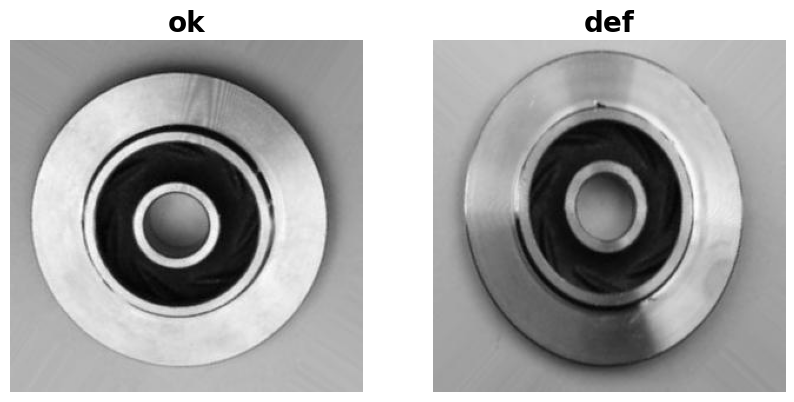

In [15]:
plt.figure(figsize=(10,8))
ok = plt.imread(train_path + 'ok_front/cast_ok_0_1.jpeg')
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("ok", weight='bold', size=20)
plt.imshow(ok,cmap='gray')

ng = plt.imread(train_path + 'def_front/cast_def_0_1001.jpeg')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("def", weight='bold', size=20)
plt.imshow(ng,cmap='gray')

plt.show()

# Preprocessnig
When training with image data without data augmentation, we only need to specify the amount of data and create a mini-batch. When performing data augmentation, after the data is acquired, various augmentation techniques are applied to the images to create new mini-batches.
The main parameters of data enhancement technology (Keras ImageDataGenerator) are as follows:

- rotation_range : rotate the image (e.g. 50 -> rotate randomly in the range -50°~50°)
- Zoom_range : Zoom in/out the image (eg 0.5 -> 1-0.5~1+0.5 random zoom in/out)
- Brightness_range : change brightness (e.g. [0.3,1.0] -> change randomly in [0.3,1.0])
- Vertical_flip : flip the image upside down
- Horizontal_flip : flips the image left or right
- height_shift_range : shift image up or down in parallel (e.g. 0.3 -> random up/down in [-0.3*Height, 0.3*Height] )
- width_shift_range : Shift image left or right in parallel (e.g. 0.3 -> shift left/right randomly in [-0.3*Width, 0.3*Width] )
- rescale : Normalizes the image by multiplying each pixel value by a constant. (e.g. 1/255 -> normalize each pixel's RGB value between 0.0 and 1.0)

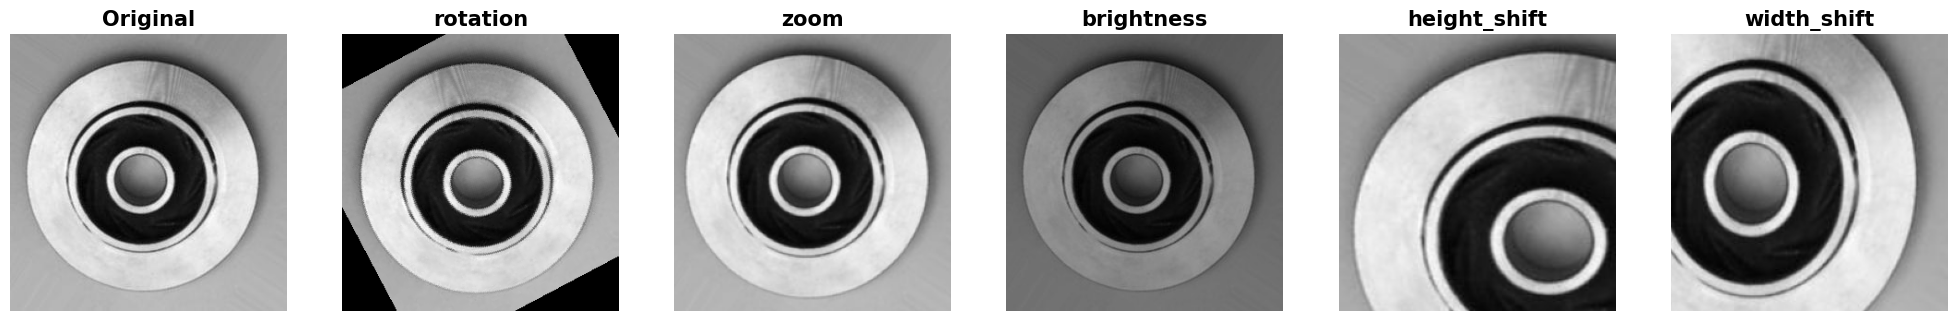

In [16]:
## take a look at the augmented data
# Read the image
img = cv2.imread(train_path + 'ok_front/cast_ok_0_1.jpeg')  # load data
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV读取的是BGR格式，转换为RGB格式

# Initialize the plot
plt.figure(figsize=(25, 10))

# Original Image
plt.subplot(1, 6, 1)
plt.title("Original", weight='bold', size=15)
plt.imshow(img)
plt.axis('off')

# Define transformations (augmentations)
generators = {
    "rotation": transforms.RandomRotation(180),
    "zoom": transforms.RandomResizedCrop(224, scale=(0.3, 1.0)),
    "brightness": transforms.ColorJitter(brightness=[0.2, 1.0]),
    "height_shift": transforms.RandomResizedCrop(224, scale=(0.3, 1.0), ratio=(0.5, 1.5)),
    "width_shift": transforms.RandomResizedCrop(224, scale=(0.3, 1.0), ratio=(0.5, 1.5))
}

cnt = 2
for param, transform in generators.items():
    pil_img = Image.fromarray(img)
    transformed_img = transform(pil_img)
    transformed_img_np = np.array(transformed_img)

    plt.subplot(1, 6, cnt)
    plt.title(param, weight='bold', size=15)
    plt.imshow(transformed_img_np)
    plt.axis('off')
    cnt += 1

# Show plot
plt.show()


In [17]:
## create dataload with data augmentation 
# Set parameters
image_shape = (300, 300)
batch_size = 32

# Image transformations
transform = transforms.Compose([
    transforms.Resize(image_shape),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=[0.9, 1.0]),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Rescale to [0, 1]
])

# Create train and validation loader

dataset = datasets.ImageFolder(train_path, transform=transform, 
                                     is_valid_file=lambda x: x.endswith('.jpeg'))  # Or any other image extension you're using

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
# create test loader

test_dataset = datasets.ImageFolder(test_path, transform=transform, 
                                    is_valid_file=lambda x: x.endswith('.jpeg'))  # Or any other image extension you're using
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Set class mappings manually
train_dataset.class_to_idx = {'def_front': 0, 'ok_front': 1}
test_dataset.class_to_idx = {'def_front': 0, 'ok_front': 1}


# Modelling
增加对模型的介绍
## simple cnn

In [18]:


class SimpleCNN(nn.Module):
    def __init__(self, image_shape):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(image_shape[2], 16, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #self.fc1 = nn.Linear(64 * (image_shape[0] // 8) * (image_shape[1] // 8), 224)
        self.fc1 = nn.Linear(20736, 224) # magic number
        self.fc2 = nn.Linear(224, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

# Create the model
image_shape = (300, 300, 1)  # H x W x C
model = SimpleCNN(image_shape)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Display model architecture
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=20736, out_features=224, bias=True)
  (fc2): Linear(in_features=224, out_features=1, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [9]:
# # Create a dummy input that matches the input dimensions of the model
# # Assuming the model expects (batch_size, channels, height, width)
# dummy_input = torch.randn(1, 1, 300, 300)  # Here, batch_size = 1, channels (grayscale) = 1, height = 300, width = 300

# # Make sure your model is on the same device as the dummy input
# model = model.to('cpu') 

# # Forward pass with dummy input
# output = model(dummy_input)

# # Visualize the computational graph
# dot = make_dot(output, params=dict(model.named_parameters()))
# dot.render("model_graph", format="png", cleanup=True)

class EarlyStopping:
    def __init__(self, patience=2, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'casting_product_detection.pth')
        self.val_loss_min = val_loss



# Initialize early stopping and model checkpoint
early_stopping = EarlyStopping(patience=2, verbose=True)

n_epochs = 20
model_history = {'loss': [], 'val_loss': []}

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader):
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(1), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    model_history['loss'].append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            inputs, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(1), labels.float())
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    model_history['val_loss'].append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

    # Early stopping and model checkpointing
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Save model history to JSON
with open('model_history.json', 'w') as f:
    json.dump(model_history, f, indent=4)


100%|██████████| 23/23 [00:04<00:00,  5.04it/s]


Epoch 1, Train Loss: 0.5555117368124999, Val Loss: 0.48103746123935864
Validation loss decreased (inf --> 0.481037).  Saving model ...


100%|██████████| 23/23 [00:04<00:00,  5.38it/s]


Epoch 2, Train Loss: 0.43118879793641657, Val Loss: 0.4416612704163012
Validation loss decreased (0.481037 --> 0.441661).  Saving model ...


100%|██████████| 23/23 [00:04<00:00,  5.41it/s]


Epoch 3, Train Loss: 0.33144823211030316, Val Loss: 0.2657666646915933
Validation loss decreased (0.441661 --> 0.265767).  Saving model ...


100%|██████████| 23/23 [00:04<00:00,  5.48it/s]


Epoch 4, Train Loss: 0.2628112570919956, Val Loss: 0.23140203758426334
Validation loss decreased (0.265767 --> 0.231402).  Saving model ...


100%|██████████| 23/23 [00:04<00:00,  5.49it/s]


Epoch 5, Train Loss: 0.2071255598253069, Val Loss: 0.16806620715752893
Validation loss decreased (0.231402 --> 0.168066).  Saving model ...


100%|██████████| 23/23 [00:04<00:00,  5.75it/s]


Epoch 6, Train Loss: 0.16666760820393953, Val Loss: 0.19774094304960707
EarlyStopping counter: 1 out of 2


100%|██████████| 23/23 [00:04<00:00,  5.38it/s]


Epoch 7, Train Loss: 0.1483994513624706, Val Loss: 0.1207359777358563
Validation loss decreased (0.168066 --> 0.120736).  Saving model ...


100%|██████████| 23/23 [00:03<00:00,  6.51it/s]


Epoch 8, Train Loss: 0.12245802790857852, Val Loss: 0.13512121898162624
EarlyStopping counter: 1 out of 2


  4%|▍         | 9/208 [00:04<01:32,  2.14it/s]


KeyboardInterrupt: 

In [ ]:
losses = pd.DataFrame(model_history)
losses.index = map(lambda x : x+1, losses.index)
losses.tail(3)